# Imports

In [63]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from influencers import top_100_crypto_influencers

In [64]:
# 1. Download BTC data
# Fetch Bitcoin (BTC) data from Yahoo Finance, between December 29, 2020, and March 13, 2021
# We're interested in the 'Close', 'High', 'Low', 'Open', and 'Volume' columns
btc = yf.download('BTC-USD', start='2020-12-29', end='2021-03-13')

# Select specific columns and reset the index to ensure a flat dataframe structure
btc = btc[['Close', 'High', 'Low', 'Open', 'Volume']].reset_index()

# Rename columns for easier readability and to avoid conflicts with other datasets
btc.columns = ['date', 'btc_close', 'btc_high', 'btc_low', 'btc_open', 'btc_volume']

# Ensure the 'date' column is in datetime format for easy manipulation and time-based operations
btc['date'] = pd.to_datetime(btc['date']) 

# 2. Technical Indicators
def add_indicators(df):
    # Simple Moving Average (SMA) over 20 days, using the closing price
    df['SMA_20'] = df['btc_close'].rolling(window=20).mean()
    
    # Daily return percentage change from the previous day's closing price
    df['Daily_Return'] = df['btc_close'].pct_change()
    
    # Rolling correlation between closing price and the 20-day SMA
    df['Close_Correlation'] = df['btc_close'].rolling(window=20).corr(df['SMA_20'])
    
    return df

# Apply the function to add the indicators to the dataframe
btc = add_indicators(btc)

# Drop rows with missing values that result from the moving averages or rolling operations
btc.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed


In [65]:
# Load the sentiment-annotated tweets dataset from the CSV file
sentiment_df = pd.read_csv('datasets/sentiment_tweets.csv')

# Ensure the 'date' column is in datetime format for easy manipulation and analysis
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])


In [66]:
# Step 1: Filter sentiment data for the top 100 crypto influencers
filtered_data = []
# Loop through each influencer in the 'top_100_crypto_influencers' list (assumed to be predefined)
for influencer in top_100_crypto_influencers:
    # Check if the influencer is present in the 'user_name' column of the sentiment dataframe
    if influencer in sentiment_df['user_name'].values:
        # If found, filter the sentiment data for that influencer and store a copy of the filtered data
        influencer_data = sentiment_df[sentiment_df['user_name'] == influencer].copy()
        filtered_data.append(influencer_data)

# Concatenate the filtered data for all influencers into a single dataframe
# If no data was added (i.e., the filtered_data list is empty), return an empty DataFrame
influencers_df = pd.concat(filtered_data, ignore_index=True) if filtered_data else pd.DataFrame()

# Step 2: Normalize the 'user_followers' values to a range between 1 and 10
# Get the minimum and maximum follower count in the sentiment dataset
min_followers = sentiment_df['user_followers'].min()
max_followers = sentiment_df['user_followers'].max()

# Define a small epsilon to avoid division by zero during normalization
epsilon = 1e-6

# Function to normalize the follower count to a scale of 1 to 10
def normalize_followers(followers):
    return 1 + 9 * ((followers - min_followers) / (max_followers - min_followers + epsilon))

# Step 3: Map sentiment labels ('Positive', 'Neutral', 'Negative') to numerical values
# Create a dictionary to map sentiment labels to numerical scores
sentiment_score = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
# Apply the mapping and store the results in a new column 'sentiment_score'
sentiment_df['sentiment_score'] = sentiment_df['sentiment'].map(sentiment_score)

# Step 4: Assign weights based on whether the user is an influencer or not
# If the user is in the list of influencers, assign a weight of 10
# Otherwise, normalize the follower count to determine the weight
sentiment_df['weight'] = sentiment_df.apply(
    lambda row: 10 if row['user_name'] in influencers_df['user_name'].values 
    else normalize_followers(row['user_followers']), axis=1
)

In [67]:
# Step 1: Group sentiment scores by date and calculate the weighted average sentiment for each day
# We group the data by the date (ignoring the time part using .dt.date) and calculate the weighted average
# The weights are based on the 'weight' column that we assigned earlier
daily_sentiment = sentiment_df.groupby(sentiment_df['date'].dt.date).apply(
    lambda x: np.average(x['sentiment_score'], weights=x['weight'])
).reset_index(name='daily_sentiment')

# Convert 'date' column to datetime format to ensure compatibility with other dataframes (e.g., BTC data)
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# Step 2: Create a date range from the minimum to the maximum date found in the BTC dataset
# This ensures that we have a continuous range of dates for the merge, including days without sentiment data
date_range = pd.date_range(start=btc['date'].min(), end=btc['date'].max())

# Step 3: Merge the daily_sentiment data with the full date range
# Create a new DataFrame with the date range and merge with 'daily_sentiment' on the 'date' column
# This ensures that every day in the date range has a corresponding sentiment value, and missing sentiment values are filled with 0
daily_sentiment = pd.DataFrame({'date': date_range}).merge(
    daily_sentiment, on='date', how='left'
).fillna({'daily_sentiment': 0})  # Fill missing sentiment values with 0

# Step 4: Merge the daily sentiment with the Bitcoin price data
# The final merge combines the BTC data with the sentiment data based on the 'date' column
# We use an 'inner' join, meaning only days that appear in both datasets will be included
merged_df = pd.merge(btc, daily_sentiment, on='date', how='inner')

In [68]:
# Step 1: Define the features for the model and create a copy of the relevant columns from merged_df
# We are selecting the columns that we want to use for prediction or analysis.
features = ['date', 'btc_close', 'SMA_20', 'Daily_Return', 'Close_Correlation', 'daily_sentiment']
data = merged_df[features].copy()

# Step 2: Define a reduced set of features by excluding the 'daily_sentiment' column
# This is for comparison or when you want to test the model with fewer features (without sentiment data).
reduced_features = ['date', 'btc_close', 'SMA_20', 'Daily_Return', 'Close_Correlation']
reduced_data = data[reduced_features].copy()

# Step 3: Add the 'Target' column for prediction
# The 'Target' is the next day's closing price (i.e., shifted by 1), which will be predicted based on the current day's features.
data['Target'] = data['btc_close'].shift(-1)
# Drop any rows with missing values that result from the shift (the last row will have NaN for 'Target')
data.dropna(inplace=True)

# Repeat the same process for the reduced data (without sentiment) 
# to prepare a version of the data that only uses the reduced features.
reduced_data['Target'] = reduced_data['btc_close'].shift(-1)
reduced_data.dropna(inplace=True)

# Step 4: Extract the numerical features (i.e., all features except 'date')
# This will be used later for machine learning models that work with numerical inputs (e.g., regression, classification).
numerical_features = [col for col in features if col != 'date']
# For the reduced features version, extract numerical features excluding 'date'.
reduced_numerical_features = [col for col in reduced_features if col != 'date']


In [69]:
# Step 1: Scaling the Features
# We use MinMaxScaler to scale the numerical features so they range from 0 to 1.
# This is important for models that are sensitive to the scale of the data, such as neural networks.
scaler = MinMaxScaler()
# Scale the numerical features of the original data (including sentiment)
X_scaled = scaler.fit_transform(data[numerical_features])
# Scale the numerical features of the reduced data (without sentiment)
X_scaled_reduced = scaler.fit_transform(reduced_data[reduced_numerical_features])

# Step 2: Define Target Variables (y)
# The target variable (y) is the next day's closing price for the BTC data.
# We are using the 'Target' column which was shifted to be the closing price of the next day.
y = data['Target'].values
# The same target variable for the reduced dataset (without sentiment)
y_r = reduced_data['Target'].values

# Step 3: Train/Test Split
# Split the data into training and testing sets (80% for training and 20% for testing).
# This allows you to train the model on a portion of the data and then evaluate its performance on unseen data.
split = int(0.8 * len(X_scaled))  # 80% of the scaled data for training
split_r = int(0.8 * len(X_scaled_reduced))  # 80% of the scaled reduced data for training

# Split the original scaled data (with sentiment)
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y[:split], y[split:]

# Split the reduced scaled data (without sentiment)
X_train_r, X_test_r = X_scaled_reduced[:split_r], X_scaled_reduced[split_r:]
y_train_r, y_test_r = y_r[:split_r], y_r[split_r:]

In [70]:
# Step 8: Train the Linear Regression Model
# Create and train a Linear Regression model on the original data (with sentiment features).
model = LinearRegression()
model.fit(X_train, y_train)  # Fit the model using the training data

# Create and train another Linear Regression model on the reduced data (without sentiment features).
model_r = LinearRegression()
model_r.fit(X_train_r, y_train_r)  # Fit the reduced model using the training data

# Step 9: Predict using the trained models
# Use the trained model to make predictions on the test data (with sentiment features).
y_pred = model.predict(X_test)

# Use the trained reduced model to make predictions on the test data (without sentiment features).
y_pred_r = model_r.predict(X_test_r)

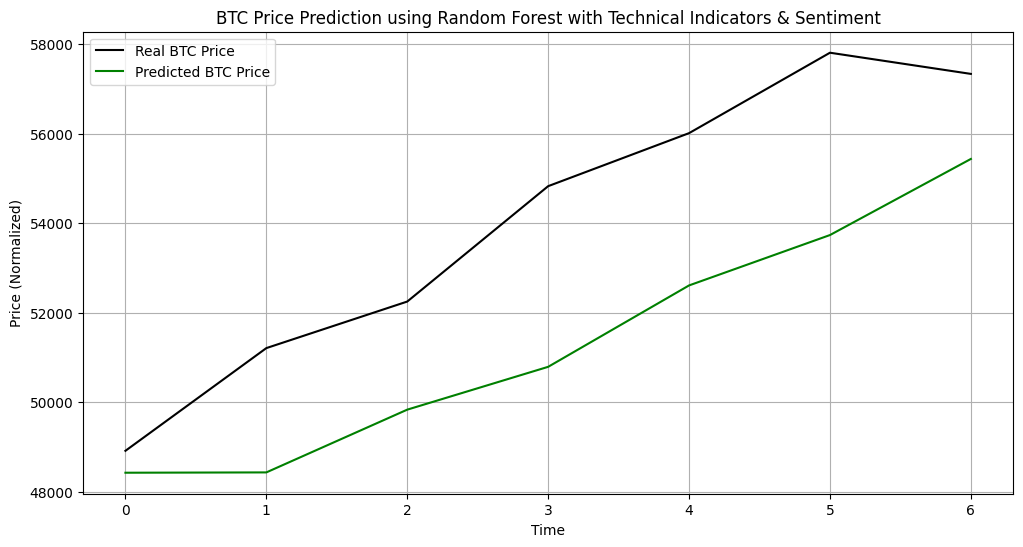

In [71]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Real BTC Price', color='black')
plt.plot(y_pred, label='Predicted BTC Price', color='green')
plt.title('BTC Price Prediction using Random Forest with Technical Indicators & Sentiment')
plt.xlabel('Time')
plt.ylabel('Price (Normalized)')
plt.legend()
plt.grid()
plt.show()

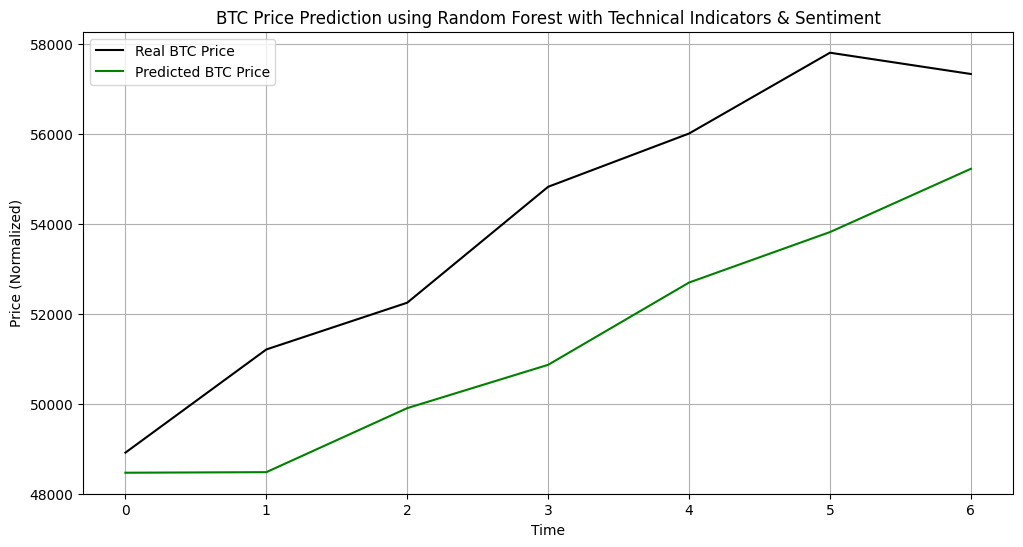

In [72]:
plt.figure(figsize=(12,6))
plt.plot(y_test_r, label='Real BTC Price', color='black')
plt.plot(y_pred_r, label='Predicted BTC Price', color='green')
plt.title('BTC Price Prediction using Random Forest with Technical Indicators & Sentiment')
plt.xlabel('Time')
plt.ylabel('Price (Normalized)')
plt.legend()
plt.grid()
plt.show()

In [73]:
# Step 1: Sharpe Ratio Function
# The Sharpe ratio is a measure of risk-adjusted return, calculated as the average return divided by the standard deviation of returns.
# A higher Sharpe ratio indicates better risk-adjusted performance. It is calculated by multiplying by the square root of 35, which is the time range of our study(in days).
def sharpe_ratio(returns):
    return np.mean(returns) / np.std(returns) * np.sqrt(35)

# Step 2: Geometric Mean Return Function
# The geometric mean return gives a more accurate representation of the average return over time, especially when returns are compounded.
# It is calculated as the nth root of the product of (1 + each return), minus 1.
def geometric_mean_return(returns):
    return (np.prod(1 + returns) ** (1 / len(returns))) - 1

# Step 3: Max Drawdown Function
# Max Drawdown calculates the largest drop from a peak to a trough during a specific period of time.
# It is a key risk metric for understanding the worst-case loss an investor could face.
def max_drawdown(returns):
    cum_returns = (1 + returns).cumprod()  # Cumulative product of returns
    peak = cum_returns.cummax()  # The highest value of the cumulative returns over time
    drawdown = (cum_returns - peak) / peak  # Calculate drawdown relative to peak
    return drawdown.min()  # Return the maximum drawdown (the largest negative drawdown)

# Step 4: Performance Evaluation Function (Full Data)
# This function evaluates the performance of a trading strategy by calculating:
# - Sharpe Ratio: A measure of risk-adjusted return
# - Geometric Mean Return: The average return over time
# - Max Drawdown: The largest loss relative to the peak
# It also plots the cumulative strategy returns over time.
def evaluate_performance(data):
    # Calculate and print performance metrics
    print("Sharpe Ratio:", sharpe_ratio(data["Strategy_Return"].dropna()))
    print("Geometric Mean Return:", geometric_mean_return(data["Strategy_Return"].dropna()))
    print("Max Drawdown:", max_drawdown(data["Strategy_Return"].dropna()))
    
    # Plot cumulative strategy returns (cumulative sum of returns)
    data[["Strategy_Return"]].cumsum().plot(title="Cumulative Strategy Returns")
    plt.show()

# Step 5: Performance Evaluation Function (Reduced Data)
# This is similar to the full data evaluation but works with a reduced dataset.
def evaluate_performance_r(reduced_data):
    print("Sharpe Ratio:", sharpe_ratio(reduced_data["Strategy_Return"].dropna()))
    print("Geometric Mean Return:", geometric_mean_return(reduced_data["Strategy_Return"].dropna()))
    print("Max Drawdown:", max_drawdown(reduced_data["Strategy_Return"].dropna()))
    
    # Plot cumulative strategy returns (cumulative sum of returns)
    reduced_data[["Strategy_Return"]].cumsum().plot(title="Cumulative Strategy Returns")
    plt.show()

# Step 6: Adding Strategy Returns to Data
# In this case, 'Strategy_Return' is set equal to the 'Daily_Return' from the BTC data. 
# This might represent a basic strategy where you are just holding BTC and tracking daily returns.
btc['Strategy_Return'] = btc['Daily_Return']

In [74]:
# Calculate RMSE (Root Mean Squared Error)
# A lower RMSE indicates a better fit of the model to the data.

# Calculate RMSE for the model with sentiment data
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# Calculate RMSE for the model without sentiment data
rmse_r = np.sqrt(mean_squared_error(y_test_r, y_pred_r))

Root Mean Squared Error (Full Features): 2972.23
Sharpe Ratio: 1.617261560416034
Geometric Mean Return: 0.012295610125399703
Max Drawdown: -0.21554027752187924


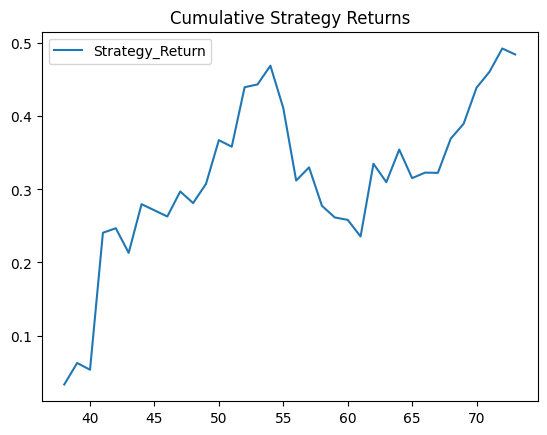

Root Mean Squared Error without Sentiment: 2931.23
Sharpe Ratio: 1.617261560416034
Geometric Mean Return: 0.012295610125399703
Max Drawdown: -0.21554027752187924


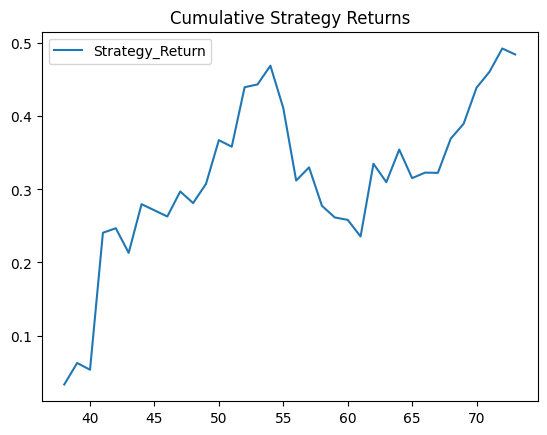

In [75]:
# Print the Root Mean Squared Error (RMSE) for the model with full features (including sentiment data)
print(f'Root Mean Squared Error (Full Features): {rmse:.2f}')

# Evaluate the performance of the model with full features
evaluate_performance(btc)

# Print the Root Mean Squared Error (RMSE) for the model without sentiment data (reduced features)
print(f'Root Mean Squared Error without Sentiment: {rmse_r:.2f}')

# Evaluate the performance of the model without sentiment data
evaluate_performance_r(btc)